# Bayesian Data Analysis in Python

## Chapter 3

In [24]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import seaborn as sns
from matplotlib import pyplot as plt

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [25]:
tosses = [1, 0, 0, 1, 0, 1, 1, 1, 0, 1]

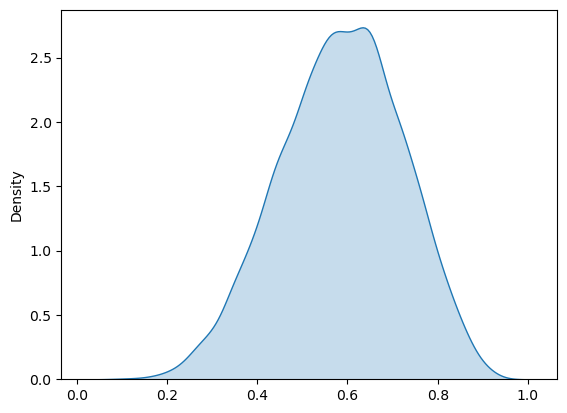

In [26]:
# Set prior parameters and calculate number of successes
beta_prior_a = 1
beta_prior_b = 1
num_successes = np.sum(tosses)

# Generate 10000 posterior draws
posterior_draws = np.random.beta(
  num_successes + beta_prior_a, 
  len(tosses) - num_successes + beta_prior_b, 
  10000)  

# Plot density of posterior_draws
sns.kdeplot(posterior_draws, fill=True)
plt.show()

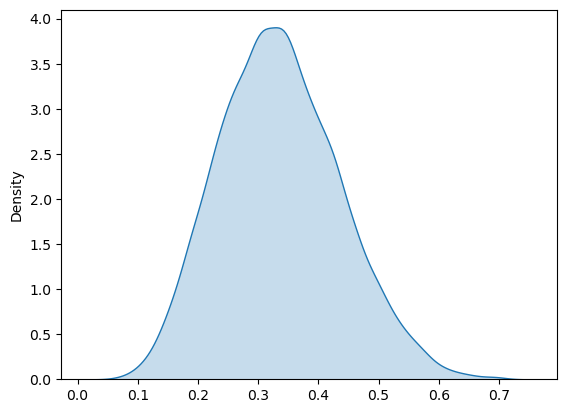

In [27]:
# Set prior parameters and calculate number of successes
beta_prior_a = 1
beta_prior_b = 10
num_successes = np.sum(tosses)

# Generate 10000 posterior draws
posterior_draws = np.random.beta(
  num_successes + beta_prior_a, 
  len(tosses) - num_successes + beta_prior_b, 
  10000)    

# Plot density of posterior_draws
sns.kdeplot(posterior_draws, fill=True)
plt.show()

based on the binomial data and the prior, it samples posterior draws. Notice how using the Beta(1, 10) prior shifts the posterior to the left compared to Beta(1, 1). This effect is quite strong, as there is little data: just 10 coin flips. 

In [28]:
ads = pd.read_csv("ads.csv")
ads

,user_id,product,site_version,time,banner_clicked
0,f500b9f27ac611426935de6f7a52b71f,clothes,desktop,2019-01-28 16:47:08,0
1,cb4347c030a063c63a555a354984562f,sneakers,mobile,2019-03-31 17:34:59,0
2,89cec38a654319548af585f4c1c76b51,clothes,mobile,2019-02-06 09:22:50,0
3,1d4ea406d45686bdbb49476576a1a985,sneakers,mobile,2019-05-23 08:07:07,0
4,d14b9468a1f9a405fa801a64920367fe,clothes,mobile,2019-01-28 08:16:37,0
...,...,...,...,...,...
9995,7ca28ccde263a675d7ab7060e9ed0eca,clothes,mobile,2019-02-02 08:19:39,0
9996,7e2ec2631332c6c4527a1b78c7ede789,clothes,mobile,2019-04-04 03:27:05,0
9997,3b828da744e5785f1e67b5df3fda5571,clothes,mobile,2019-04-15 15:59:06,0
9998,6cce0527245bcc8519d698af2224c04a,clothes,mobile,2019-05-21 20:43:21,0


In [29]:
def simulate_beta_posterior(trials, beta_prior_a, beta_prior_b):
    num_successes = np.sum(trials)
    posterior_draws = np.random.beta(
        num_successes + beta_prior_a,
        len(trials) - num_successes + beta_prior_b,
        10000
    )

    return posterior_draws

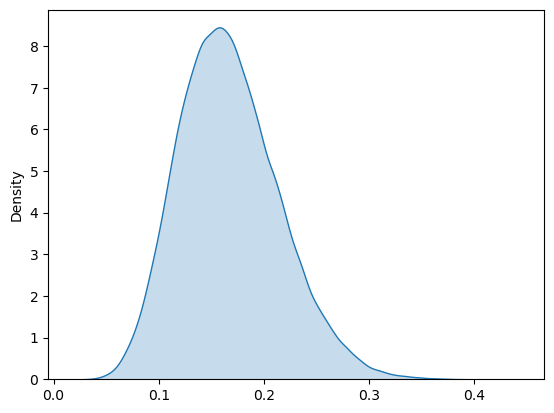

In [30]:
# Generate prior draws
prior_draws = np.random.beta(10, 50, 100000)

# Plot the prior
sns.kdeplot(prior_draws, fill=True, label="prior")
plt.show()

# Extract the banner_clicked column for each product
clothes_clicked = ads.loc[ads["product"] == "clothes"]["banner_clicked"]
sneakers_clicked = ads.loc[ads["product"] == "sneakers"]["banner_clicked"]

# Simulate posterior draws for each product
clothes_posterior = simulate_beta_posterior(clothes_clicked, 10, 50)
sneakers_posterior = simulate_beta_posterior(sneakers_clicked, 10, 50)

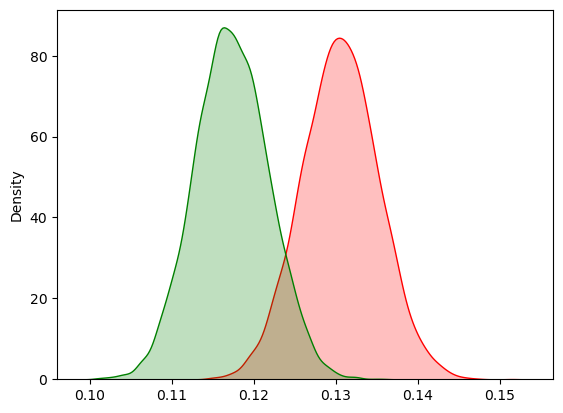

In [31]:
sns.kdeplot(clothes_posterior, fill=True, label="clothes", color="red")
sns.kdeplot(sneakers_posterior, fill=True, label="sneakers", color="green")
plt.show()

Since the two posteriors overlap, so it is actually possible for the sneakers campaign to be better. 

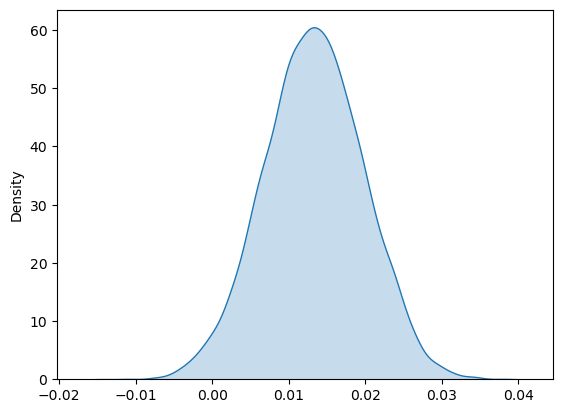

[0.0024815 0.0237568]
0.9783


In [32]:
# Calculate posterior difference and plot it
diff = clothes_posterior - sneakers_posterior
sns.kdeplot(diff, fill=True, label="diff")
plt.show()

# Calculate and print 90% credible interval of posterior difference
interval = az.hdi(diff, hdi_prob=0.9)
print(interval)

# Calculate and print probability of clothes ad being better
clothes_better_prob = (diff > 0).mean()
print(clothes_better_prob)

Take a look at the posterior density plot of the difference in click rates: it is very likely positive, indicating that clothes are likely better. The credible interval indicates that with 90% probability, the clothes ads click rate is up to 2.4 percentage points higher than the one for sneakers. Finally, the probability that the clothes click rate is higher is 98%. Great! But there is a 2% chance that actually sneakers ads are better!

In [33]:
# Slice diff to take only cases where it is negative
loss = diff[diff < 0]

# Compute and print expected loss
expected_loss = loss.mean()
print(expected_loss)

-0.0022527980577485905


You can sefely roll out the clothes campaign to a larger audience. You are 98% sure it has a higher click rare, and even if the 2% risk of this being a wrong decision materializes, you will only lose 0.2 percentage points in the click rate, which is a very small risk!

In [34]:
# Calculate distributions of the numbers of clicks for clothes and sneakers
clothes_num_clicks = clothes_posterior * 10000
sneakers_num_clicks = sneakers_posterior * 10000

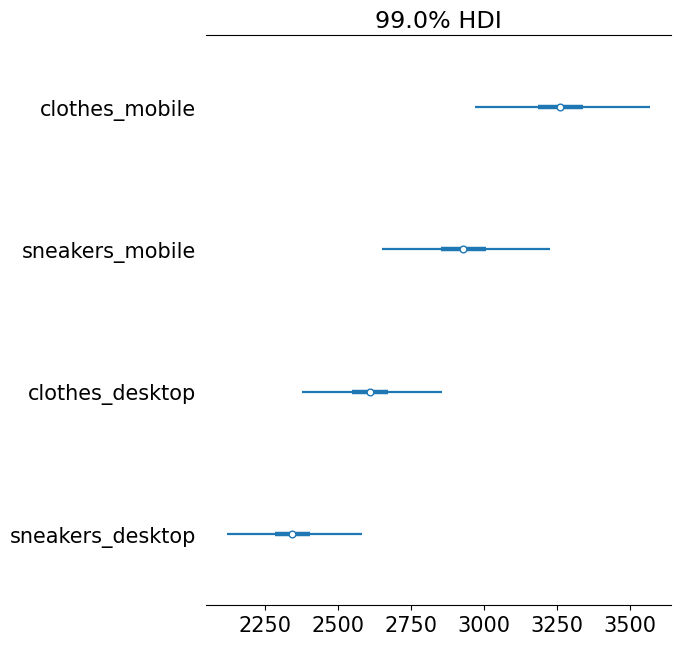

In [37]:
# Calculate distributions of the numbers of clicks for clothes and sneakers
clothes_num_clicks = clothes_posterior * 10_000
sneakers_num_clicks = sneakers_posterior * 10_000

# Calculate cost distributions for each product and platform
ads_costs = {
    "clothes_mobile": clothes_num_clicks * 2.5,
    "sneakers_mobile": sneakers_num_clicks * 2.5,
    "clothes_desktop": clothes_num_clicks * 2.0,
    "sneakers_desktop": sneakers_num_clicks * 2.0,
}

# Draw a forest plot of ads_costs
pm.plot_forest(ads_costs, hdi_prob=0.99, textsize=15)
plt.show()

It's completely impossible for the clothes-mobile cost to be lower than the sneakers-desktop cost. This statement is FALSE.
The ends of the whiskers mark the 99% credible interval, so there is a 1% chance the cost will fall outside of it. It's very, very unlikely, but there is a slim chance that the clothes-mobile cost will turn out lower. It's important to stay cautious when communicating possible scenarios -- that's the thing with probability, it's rarely the case that something is 'completely impossible'!

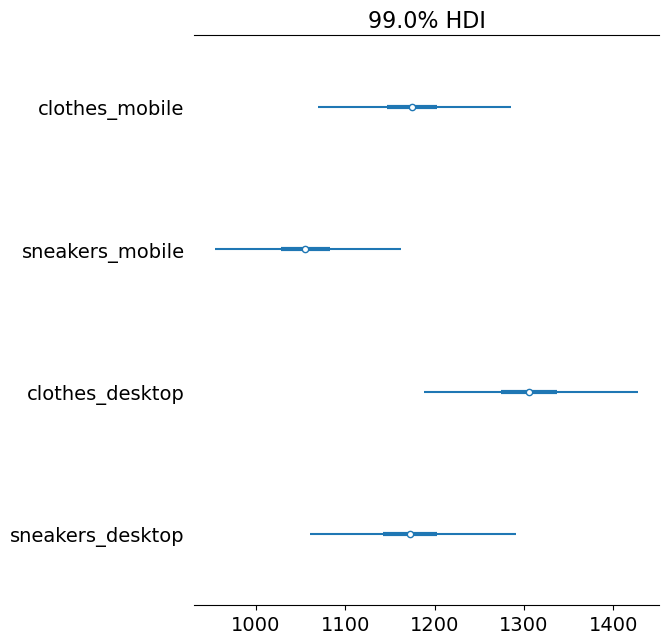

In [40]:
# Calculate profit distributions for each product and platform
ads_profit = {    
    "clothes_mobile": clothes_num_clicks * 3.4-clothes_num_clicks * 2.5,
    "sneakers_mobile": sneakers_num_clicks * 3.4-sneakers_num_clicks *2.5,
    "clothes_desktop": clothes_num_clicks * 3.0 - clothes_num_clicks * 2.0,
    "sneakers_desktop": sneakers_num_clicks * 3.0 - sneakers_num_clicks * 2.0,
}

# Draw a forest plot of ads_profit
pm.plot_forest(ads_profit, hdi_prob=0.99)
plt.show()

Notice how shifting focus from costs to profit has changed the optimal decision. The sneakers-desktop campaign which minimizes the cost is not the best choice when you care about the profit. Based on these results, you would be more likely to invest in the clothes-desktop campaign

In [41]:
intercept_draws = np.random.normal(1.28, 0.904, 2000)
clothes_draws = np.random.normal(0.105, 0.030, 2000)
sneakers_draws = np.random.normal(0.104, 0.032, 2000)
sd_draws = np.random.normal(2.652, 0.159, 2000)

       intercept_draws  clothes_draws  sneakers_draws     sd_draws
count      2000.000000    2000.000000     2000.000000  2000.000000
mean          1.286668       0.105777        0.104574     2.652224
std           0.916255       0.029878        0.032343     0.161056
min          -1.829603       0.000340       -0.021536     2.183770
25%           0.684844       0.086315        0.082779     2.536816
50%           1.286965       0.104986        0.103612     2.649399
75%           1.911134       0.125985        0.126215     2.762132
max           3.984477       0.199478        0.211485     3.300805


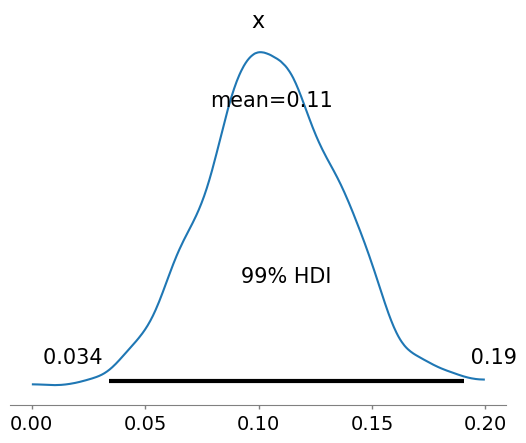

In [42]:
# Collect parameter draws in a DataFrame
posterior_draws_df = pd.DataFrame({
    "intercept_draws": intercept_draws,
    "clothes_draws": clothes_draws,
  	"sneakers_draws": sneakers_draws,
    "sd_draws": sd_draws,
})

# Describe parameter posteriors
draws_stats = posterior_draws_df.describe()
print(draws_stats)

# Plot clothes parameter posterior
pm.plot_posterior(clothes_draws, hdi_prob=0.99)
plt.show()

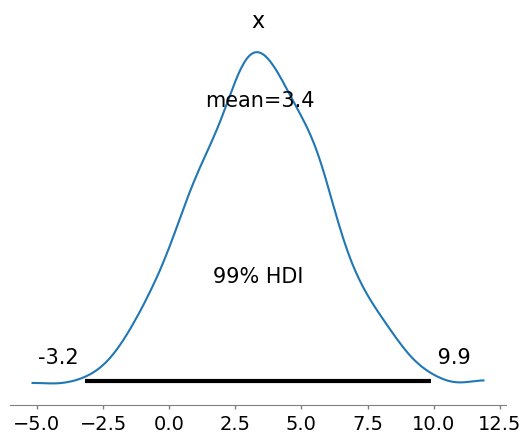

In [43]:
# Aggregate posteriors of the parameters to point estimates
intercept_coef = np.mean(intercept_draws)
sneakers_coef = np.mean(sneakers_draws)
clothes_coef = np.mean(clothes_draws)
sd_coef = np.mean(sd_draws)

# Calculate the mean of the predictive distribution
pred_mean = intercept_coef + sneakers_coef * 10 + clothes_coef * 10

# Sample 1000 draws from the predictive distribution
pred_draws = np.random.normal(pred_mean, sd_coef, size=1000)

# Plot the density of the predictive distribution
pm.plot_posterior(pred_draws,  hdi_prob=0.99)
plt.show()